# PAM for Digital Source Signals
Markus Gardill, 2019

In [1]:
import numpy as np
from sympy.combinatorics.graycode import GrayCode

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import Markdown, HTML

In [2]:
figsize_1 = (16/2.54, 10/2.54)

In [3]:
font = {'family' : 'Calibri',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

## Simulation Parameters

Sample Rate and Sample Period used for simulation

In [4]:
f_sim = 1
T_sim = 1/f_sim

Number of Bits to transmit

In [5]:
N_bits  = 20

## Modulation Parameters

Number of bits per Symbol

In [6]:
M = 2

Symbol duration

In [7]:
T_s = 10*T_sim
f_s = 1/T_s

Number of symbols necessary

In [8]:
K = 2**M
display(K)

4

## Source Signal

Create source signal as binary sequence. Use predefined `b` for generation of graphics for lecture slides, use random b for your own experiments.

In [9]:
b = np.array([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1])
#b = np.random.randint(0,2,N_bits)
display(b)

array([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1])

## Symbol Mapping

Define a function which maps 1D array `b` using `M` bits per symbol to a Gray code.
The Gray code for a given number `M` of bits can be obtained from the class `GrayCode` of `sympy.combinatorics.graycode`.
To map the array `b` of bits to the gray code symbols, first the array reshaped into a $len(b)/M \times M$ matrix, and then for each row (resulting symbol) of the matrix, the corresponding unsigned integer number representation is calculated by multiplying $2^{(M-1-l)}$ to column $l$ and then summing over the columns. Those integer numbers can then be used to index into the Gray code list.

In [10]:
def gray_code_mapper(b, M):
    b = np.asarray(b)
    # gray code list
    code_mapper = GrayCode(M)
    gray_code_list = np.array(list(code_mapper.generate_gray()))
    # compute the index into gray code list
    gray_index = np.sum(b.reshape(-1,M)*2**np.tile(np.arange(M-1,-1,-1),(b.reshape(-1,M).shape[0],1)), axis=1)
    # compute gray code represenation
    if not gray_index.size == 0:
        output_gray = gray_code_list[gray_index]
    else:
        output_gray = []
    return output_gray, gray_code_list

Display the Gray code mapping

In [11]:
_, gray_code = gray_code_mapper([], M)
display(["{0:02b}".format(val) for val in np.arange(2**M)])
display(gray_code.tolist())

['00', '01', '10', '11']

['00', '01', '11', '10']

Define the symbol mapper. For $M$-PAM equispaced symbols centered around zero are used.

In [12]:
def symbol_mapper_mpam(b, M):
    # symbols table
    table_symbols = np.arange(0, 2**M) - 2**(M-1) + 0.5
    # compute index into symbol table
    idx_symbols_table = [int(b,2) for b in b]
    return table_symbols[idx_symbols_table], table_symbols

Plot the used symbol mapping table

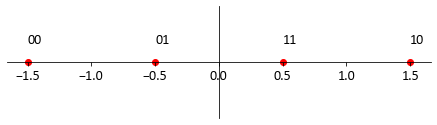

In [13]:
_, table_symbols = symbol_mapper_mpam([], M)
fig = plt.figure(figsize = np.array(figsize_1) * np.array([1,0.5]))
ax1 = plt.subplot(1,1,1)
ax1.spines['bottom'].set_position('zero')
ax1.spines['left'].set_position('zero')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.ylim([-1.5,1.5])
plt.yticks([],[])
plt.scatter(table_symbols,np.zeros(table_symbols.shape), color="red")
for k in range(table_symbols.shape[0]):
    plt.text(table_symbols[k], 0.5, f"{gray_code[k]}")
#plt.grid()
plt.tight_layout()
plt.savefig("pam_digital_constellation", dpi=300)
plt.show()

In [14]:
b_coded,_ = gray_code_mapper(b, M)
symbols, _ = symbol_mapper_mpam(b_coded, M)
t_symbols = np.arange(0, symbols.shape[0]) * T_s
display(f"Bits:{b.tolist()}")
display(f"Bits Coded:{b_coded.tolist()}")
display(f"Symbols:{symbols.tolist()}")
display(f"Symbol Times:{t_symbols}")

'Bits:[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]'

"Bits Coded:['11', '00', '01', '00', '11', '01', '00', '11', '11', '01']"

'Symbols:[1.5, -1.5, -0.5, -1.5, 1.5, -0.5, -1.5, 1.5, 1.5, -0.5]'

'Symbol Times:[ 0. 10. 20. 30. 40. 50. 60. 70. 80. 90.]'

## Ideal PAM

The upsampling factor is given as ratio of symbol duration and sample duration

In [15]:
N_up = round(T_s / T_sim)
display("Upsampling factor is {}".format(N_up))

'Upsampling factor is 10'

Upsample the signal using some array manipulation

In [16]:
sig_pam_ideal = np.concatenate([np.atleast_2d(symbols), np.zeros((N_up-1, symbols.shape[0]))]).flatten('F')
t_ideal = np.arange(0, len(sig_pam_ideal) * T_sim, T_sim)

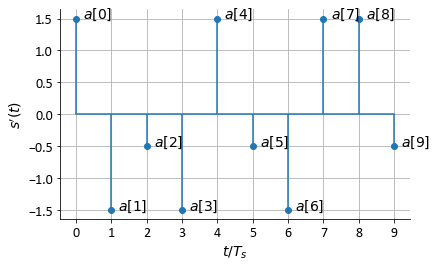

In [43]:
fig = plt.figure()
fig.set_size_inches(figsize_1)
ax = plt.subplot(1,1,1)
markerline, stemlines, baseline = ax.stem(t_symbols/T_s, symbols, use_line_collection=True)
plt.setp(baseline, "color", markerline.get_color())
for l in range(symbols.shape[0]):
    plt.text(t_symbols[l]/T_s+0.2, symbols[l], f"$a[{l}]$")
plt.xlabel('$t/T_s$')
plt.ylabel("$s'(t)$")
#ax.spines['bottom'].set_position('zero')
#ax.spines['left'].set_position('zero')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(t_symbols/T_s, (t_symbols/T_s).astype('int'))
#plt.xlim([0,t_symbols[-1]])
plt.grid()
fig.tight_layout()
plt.savefig('pam_digital_ideal', dpi = 300)
plt.show()

## Selecting an Impulse Shape

TODO

In [18]:
t_g_t = np.arange(-3*T_s, 3*T_s, T_sim)
t_g_t

array([-30., -29., -28., -27., -26., -25., -24., -23., -22., -21., -20.,
       -19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,  -9.,
        -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,
         3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,
        14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,
        25.,  26.,  27.,  28.,  29.])

In [19]:
alpha = 0.8

def raised_cosine(t, T_s, alpha):
    g_t = np.zeros(t.shape)
    denominator = (1-(4*alpha**2*t**2/T_s**2))
    g_t[denominator != 0] = np.sinc(t[denominator != 0]/T_s) * np.cos(np.pi*alpha*t[denominator != 0]/T_s) / denominator[denominator != 0]
    g_t[denominator == 0] = np.sinc(t[denominator == 0]/T_s)
    return g_t

g_t = raised_cosine(t_g_t, T_s, alpha)

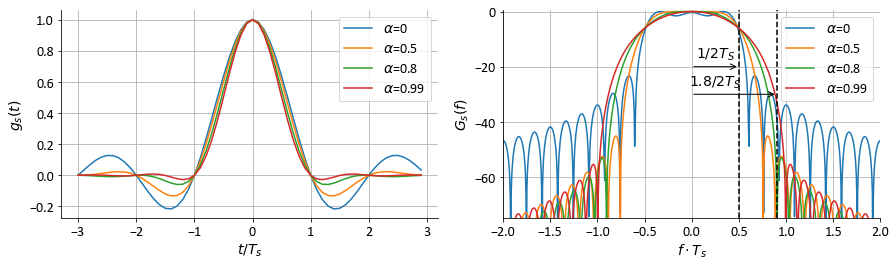

In [52]:
alphas = [0,0.5,0.8,0.99]
fig = plt.figure(figsize = np.array(figsize_1)*np.array([2,1]))

ax = plt.subplot(1,2,1)
for alpha in alphas:
    g_t_current = raised_cosine(t_g_t, T_s, alpha)
    plt.plot(t_g_t/T_s, g_t_current, label=f'$\\alpha$={alpha}')
#ax.spines['bottom'].set_position('zero')
#ax.spines['left'].set_position('zero')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("$t/T_s$")
plt.ylabel("$g_s(t)$")
plt.grid()
plt.legend()

ax = plt.subplot(1,2,2)
for alpha in alphas:
    g_t_current = raised_cosine(t_g_t, T_s, alpha)
    G_t_current = np.fft.fft(g_t_current, 2048)
    freqs_G_t_current = np.fft.fftfreq(G_t_current.shape[0], T_sim)
    plt.plot(np.fft.fftshift(freqs_G_t_current/f_s), np.fft.fftshift(20*np.log10(np.abs(G_t_current)/np.max(np.abs(G_t_current)))), label=f'$\\alpha$={alpha}')

vlines = []
vlines.append(ax.axvline(1/T_s/2/f_s))
vlines.append(ax.axvline(1.8/T_s/2/f_s))
for vline in vlines:
    vline.set_color('black')
    vline.set_linestyle('--')
ax.annotate("", xy=(0, -20), xytext=(1/T_s/2/f_s, -20), arrowprops=dict(arrowstyle="<-"))
plt.text(1/T_s/2/f_s/2,-17,"$1/2T_{S}$", horizontalalignment="center")
ax.annotate("", xy=(0, -30), xytext=(1.8/T_s/2/f_s, -30), arrowprops=dict(arrowstyle="<-"))
plt.text(1/T_s/2/f_s/2,-27,"$1.8/2T_{S}$", horizontalalignment="center")
#ax.spines['bottom'].set_position('zero')
#ax.spines['left'].set_position('zero')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("$f \cdot T_s$")
plt.ylabel("$G_s(f)$")
plt.xlim([-2/T_s/f_s, 2/T_s/f_s])
plt.ylim([-75, 0.5])
plt.grid()
plt.legend()

fig.tight_layout()
plt.savefig("pam_digital_g_t", dpi=300)
plt.show()

## PAM With Impulse Shaping

Create individual shifted copies of $g_T(t)$; column $k$ of `sig_pam_g_t_copies` thus represents
$$
v[k] g_T(t-kT_S)
$$

In [21]:
t_g_t_copies = np.arange(np.min(t_g_t), len(symbols)*N_up+np.max(t_g_t), T_sim)
sig_pam_g_t_copies = np.zeros((t_g_t_copies.shape[0], symbols.shape[0]))
idx_g_t_center = np.argwhere(t_g_t == 0)[0][0]
for k in range(symbols.shape[0]):
    idx_current_symbol = np.argwhere(t_g_t_copies == k*T_s)[0][0]
    idx_start = idx_current_symbol - idx_g_t_center
    idx_end = idx_start + len(g_t)
    sig_pam_g_t_copies[idx_start:idx_end, k] = g_t * symbols[k]

Generate PAM with impulse shaping by convolution

In [22]:
sig_pam_filtered = np.convolve(sig_pam_ideal, g_t)[round(len(g_t)/2):-round(len(g_t)/2)+1]

Plot the signals

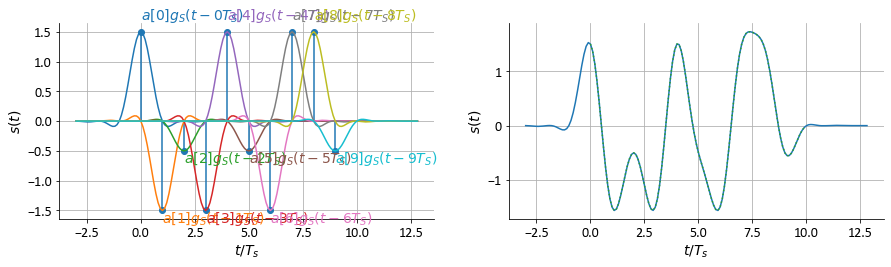

In [23]:
fig = plt.figure()
fig.set_size_inches(np.array(figsize_1) * np.array([2,1]) )

ax = plt.subplot(1,2,1)
markerline, stemlines, baseline = ax.stem(t_symbols/T_s, symbols, use_line_collection=True)
plt.setp(baseline, "color", markerline.get_color())
plt.plot(t_g_t_copies/T_s, sig_pam_g_t_copies)
for l in range(symbols.shape[0]):
    plt.text(t_symbols[l]/T_s, symbols[l]+0.2*np.sign(symbols[l]), f"$a[{l}]g_S(t-{l}T_S)$", color=f"C{l}")
#ax.spines['bottom'].set_position('zero')
#ax.spines['left'].set_position('zero')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid("both")
plt.xlabel("$t/T_s$")
plt.ylabel("$s(t)$")

ax = plt.subplot(1,2,2)
plt.plot(t_g_t_copies/T_s,np.sum(sig_pam_g_t_copies, axis=1), '-')
plt.plot(t_ideal/T_s, sig_pam_filtered, 'C2:')
#plt.plot(t_ideal, sig_pam_ideal)
#plt.grid()
#ax.spines['bottom'].set_position('zero')
#ax.spines['left'].set_position('zero')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid("both")
plt.xlabel("$t/T_s$")
plt.ylabel("$s(t)$")
plt.tight_layout()
plt.savefig("pam_digital_real", dpi=300)
plt.show()

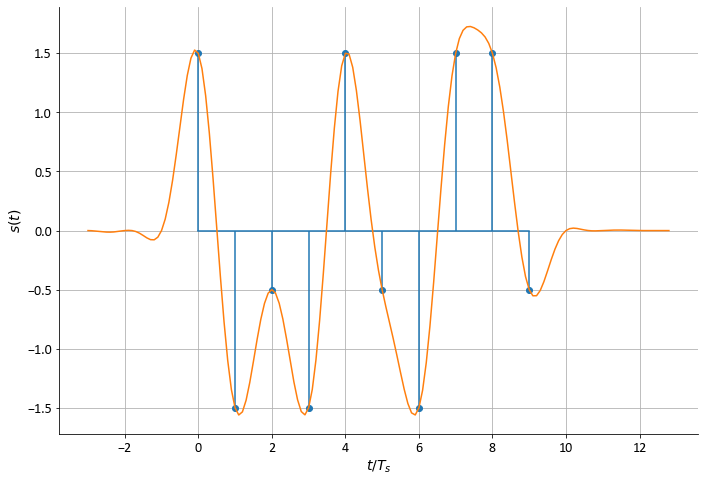

In [24]:
fig = plt.figure()
fig.set_size_inches(np.array(figsize_1) * np.array([4,2]) )
ax = plt.subplot(1,2,1)
markerline, stemlines, baseline = ax.stem(t_symbols/T_s, symbols, use_line_collection=True)
plt.setp(baseline, "color", markerline.get_color())

#ax.spines['bottom'].set_position('zero')
#ax.spines['left'].set_position('zero')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid()
plt.xlabel("$t/T_s$")
plt.ylabel("$s(t)$")

lines = plt.plot(t_g_t_copies/T_s,sig_pam_g_t_copies)
labels = []
for l in range(symbols.shape[0]):
    labels.append(plt.text(t_symbols[l]/T_s, symbols[l]+0.2*np.sign(symbols[l]), f"$a[{l}]g_S(t-{l}T_S)$", color=f"C{l}"))


ims = []

ims.append([])

for l in range(symbols.shape[0]):
    ims.append([*lines[:l+1], labels[l]])
    
ims.append((plt.plot(t_g_t_copies/T_s,np.sum(sig_pam_g_t_copies, axis=1),'C1')))

im_ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=3000, blit=True)
HTML(im_ani.to_jshtml(fps=1))

## Spectral Properties of PAM Signal

### General Spectral Properties

Fourier transform of transmit impulse

In [25]:
G_t = np.fft.fft(g_t, 2**12)
freqs_G_t = np.fft.fftfreq(G_t.shape[0], T_sim)

Generate a very long signal to get sufficient signal statistics

In [26]:
b_very_long,_ = gray_code_mapper(np.random.randint(0,2,2**18), M)
symbols_very_long, _ = symbol_mapper_mpam(b_very_long, M)
sig_pam_ideal_very_long = np.concatenate([np.atleast_2d(symbols_very_long), np.zeros((N_up-1, symbols_very_long.shape[0]))]).flatten('F')
sig_pam_filtered_very_long = np.convolve(sig_pam_ideal_very_long, g_t)[round(len(g_t)/2):-round(len(g_t)/2)+1]

Generate a very long, strongly correlated signal

In [27]:
b_very_long_corr,_ = gray_code_mapper(np.repeat(np.random.randint(0,2,2**10),2**8), M)
symbols_very_long_corr, _ = symbol_mapper_mpam(b_very_long_corr, M)
sig_pam_ideal_very_long_corr = np.concatenate([np.atleast_2d(symbols_very_long_corr), np.zeros((N_up-1, symbols_very_long_corr.shape[0]))]).flatten('F')
sig_pam_filtered_very_long_corr = np.convolve(sig_pam_ideal_very_long_corr, g_t)[round(len(g_t)/2):-round(len(g_t)/2)+1]

Fourier transform of transmit signal

In [28]:
S_t = np.fft.fft(sig_pam_filtered_very_long)
S_t_corr = np.fft.fft(sig_pam_filtered_very_long_corr)
freqs_S_t = np.fft.fftfreq(S_t.shape[0], T_sim)

Plot spectra

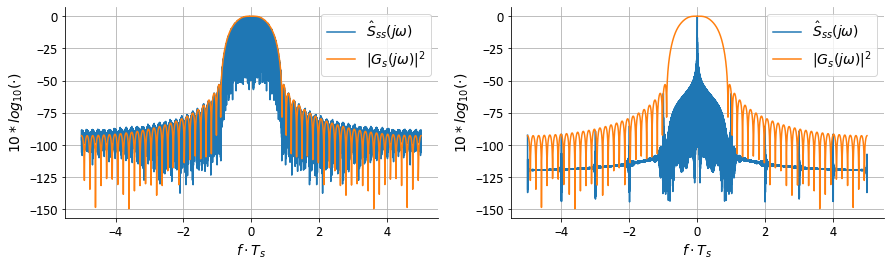

In [29]:
fig = plt.figure(figsize=np.array(figsize_1)*np.array([2,1]))

ax1 = plt.subplot(1,2,1)
plt2 = plt.plot(np.fft.fftshift(freqs_S_t*T_s), np.fft.fftshift(10*np.log10(np.abs(S_t)**2/np.max(np.abs(S_t)**2))), label="$\hat{S}_{ss}(j\omega)$")
plt1 = plt.plot(np.fft.fftshift(freqs_G_t*T_s), np.fft.fftshift(10*np.log10(np.abs(G_t)**2/np.max(np.abs(G_t)**2))), label="$|G_s(j\omega)|^2$")
#ax.spines['bottom'].set_position('zero')
#ax.spines['left'].set_position('zero')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.grid()
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlabel("$f \cdot T_s$")
plt.ylabel("$10*log_{10}(\cdot)$")

ax2 = plt.subplot(1,2,2)
plt2 = plt.plot(np.fft.fftshift(freqs_S_t*T_s), np.fft.fftshift(10*np.log10(np.abs(S_t_corr)**2/np.max(np.abs(S_t_corr)**2))), label="$\hat{S}_{ss}(j\omega)$")
plt1 = plt.plot(np.fft.fftshift(freqs_G_t*T_s), np.fft.fftshift(10*np.log10(np.abs(G_t)**2/np.max(np.abs(G_t)**2))), label="$|G_s(j\omega)|^2$")
#ax.spines['bottom'].set_position('zero')
#ax.spines['left'].set_position('zero')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.grid()
plt.legend(loc='upper right')
plt.xlabel("$f \cdot T_s$")
plt.ylabel("$10*log_{10}(\cdot)$")
plt.tight_layout()
plt.savefig("pam_digital_spectrum", dpi=300)
plt.show()

### Generating Passband Signals

Define carrier frequency to use for passband transmission; by defining the carrier frequency relative to the simulation sampling frequency `f_s`, we can ensure that the relative position of the carrier withing the specturm plots remains identical also when the sampling frequency is changed.

In [30]:
f_c = 0.2 * f_sim

Define passband version of transmit impulse by upconversion of baseband transmit impulse to `f_c`, compute its FFT and the frequencies of the FFT.

In [31]:
g_t_pb = g_t*np.cos(2*np.pi*f_c*t_g_t)
G_t_pb = np.fft.fft(g_t_pb, 2**12)
freqs_G_t_pb = np.fft.fftfreq(G_t.shape[0], T_sim)

Plot passband transmit impulse

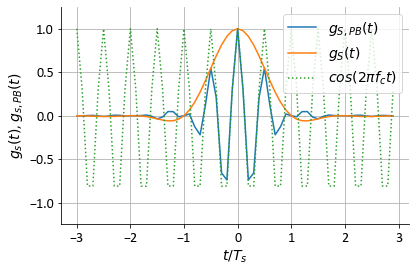

In [32]:
fig = plt.figure()
ax = plt.subplot(1,1,1)
plt.plot(t_g_t/T_s, g_t_pb, label="$g_{S,PB}(t)$")
plt.plot(t_g_t/T_s, g_t, label="$g_{S}(t)$")
plt.plot(t_g_t/T_s, np.cos(2*np.pi*f_c*t_g_t), ':', label="$cos(2 \\pi f_c t)$")
#ax.spines['bottom'].set_position('zero')
#ax.spines['left'].set_position('zero')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim([-1.25,1.25])
plt.xlabel("$t/T_s$")
plt.ylabel("$g_s(t)$, $g_{s,PB}(t)$")
plt.legend(loc="upper right")
plt.grid()
plt.tight_layout()
plt.savefig("pam_digital_g_t_passband", dpi=300)
plt.show()

Create PAM signal using the very long binary random sequence from above and the new passband transmit impulse.

In [33]:
sig_pam_ideal_very_long_pb = np.concatenate([np.atleast_2d(symbols_very_long), np.zeros((N_up-1, symbols_very_long.shape[0]))]).flatten('F')
sig_pam_filtered_very_long_pb = np.convolve(sig_pam_ideal_very_long, g_t_pb)[round(len(g_t_pb)/2):-round(len(g_t_pb)/2)+1]

Estimate spectrum by FFT (Periodogram).

In [34]:
S_t_pb = np.fft.fft(sig_pam_filtered_very_long_pb)

Plot results

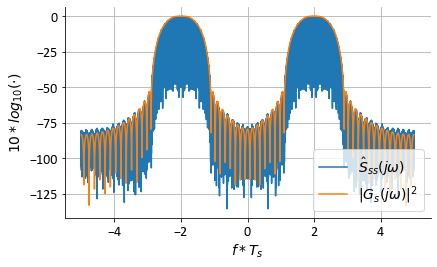

In [35]:
fig = plt.figure(figsize=np.array(figsize_1)*np.array([1,1]))

ax1 = plt.subplot(1,1,1)
plt2 = plt.plot(np.fft.fftshift(freqs_S_t*T_s), np.fft.fftshift(10*np.log10(np.abs(S_t_pb)**2/np.max(np.abs(S_t_pb)**2))), label="$\hat{S}_{ss}(j\omega)$")
plt1 = plt.plot(np.fft.fftshift(freqs_G_t_pb*T_s), np.fft.fftshift(10*np.log10(np.abs(G_t_pb)**2/np.max(np.abs(G_t_pb)**2))), label="$|G_s(j\omega)|^2$")
#ax.spines['bottom'].set_position('zero')
#ax.spines['left'].set_position('zero')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.xlabel("$f*T_s$")
plt.ylabel("$10*log_{10}(\cdot)$")
fig.tight_layout()
plt.savefig("pam_digital_spectrum_passband", dpi=300)
plt.show()

## Collection of Mini-Graphics

Ideal PAM

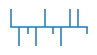

In [36]:
fig = plt.figure()
fig.set_size_inches(np.array(figsize_1)*0.25)
ax = plt.subplot(1,1,1)
markerline, stemlines, baseline = ax.stem(t_symbols, symbols, use_line_collection=True, markerfmt=" ")
plt.setp(baseline, "color", markerline.get_color())
plt.xlabel('$t$')
plt.ylabel('$s_{ID}(t)$')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(t_symbols, t_symbols)
fig.tight_layout()
plt.savefig('pam_digital_ideal_mini', dpi = 300)
plt.show()

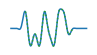

In [37]:
fig = plt.figure()
fig.set_size_inches(np.array(figsize_1) * 0.25 )
ax = plt.subplot(1,1,1)
plt.plot(t_g_t_copies,np.sum(sig_pam_g_t_copies, axis=1), '-')
plt.plot(t_ideal, sig_pam_filtered, 'C2:')
#plt.plot(t_ideal, sig_pam_ideal)
#plt.grid()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid("both")
plt.tight_layout()
plt.savefig("pam_digital_real_mini", dpi=300)
plt.show()